# 🧪 Experiment 3: Flan-T5-Small

## 🎯 Hypothesis
Flan-T5-Base (250M) was too large and harder to fine-tune. Flan-T5-Small (80M - similar to T5-Small) might provide better instruction-following with similar trainability.

## 🔬 Changes:
- ✅ Model: **google/flan-t5-small** (80M params - instruction-tuned)
- ✅ Lower learning rate: 3e-5 (Flan models need gentler fine-tuning)
- ✅ Sequence lengths: 256/512 (restored)
- ✅ Same training setup as Experiment 1
- ✅ Simpler prompt (Flan already understands instructions)

**Key Advantage:** Flan-T5 is instruction-tuned, so it should understand medical QA better

**Baseline to Beat:**
- BLEU: 0.0283
- ROUGE-L: 0.2102


In [6]:
%pip install -q tf-keras transformers tensorflow pandas numpy scikit-learn datasets evaluate rouge-score sacrebleu matplotlib seaborn
print("✓ Installed!")


✓ Installed!


In [7]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, json
from pathlib import Path
from transformers import AutoTokenizer, TFAutoModelForSeq2SeqLM
from datasets import Dataset
import evaluate, tensorflow as tf, tf_keras
from datetime import datetime

SEED = 42; np.random.seed(SEED); tf.random.set_seed(SEED)
print(f"TF: {tf.__version__}")


TF: 2.19.0


In [8]:
# Download data and model from Google Drive
%pip install -q gdown
import gdown
from pathlib import Path
import os

# Google Drive folder: https://drive.google.com/drive/folders/1qLXyEEcgz8y7-fr9oAzav2C-AaGccxqC
FOLDER_ID = "1qLXyEEcgz8y7-fr9oAzav2C-AaGccxqC"

print("Downloading files from Google Drive...")
print("This includes: best.h5 model, data files, and strategy files\n")

# Create directories if they don't exist
os.makedirs('files', exist_ok=True)

# Download entire folder
try:
    gdown.download_folder(
        id=FOLDER_ID,
        quiet=False,
        use_cookies=False,
        output="files"  # Download to a specific directory
    )
    print("\n✓ Download complete!")
except Exception as e:
    print(f"\n⚠️ Error during download: {str(e)}")
    print("Please check your internet connection and try again.")
    raise

# Verify critical files exist
print("\nVerifying files...")
critical_files = {
    'Data files': ['train_improved.csv', 'val_improved.csv', 'test_improved.csv'],
}

def find_file(filename):
    """Search for file in downloaded folder and common locations."""
    search_paths = [
        Path(filename),
    ]

    # Also search recursively in downloaded_files
    if Path('files').exists():
        for root, _, files in os.walk('files'):
            if filename in files:
                return Path(root) / filename

    for path in search_paths:
        if path.exists():
            return path
    return None

# Check and move files to correct locations if needed
for category, files in critical_files.items():
    print(f"\n{category}:")
    for file in files:
        file_path = find_file(file)
        if file_path:
            target_dir = Path('.')
            target_path = target_dir / file
        else:
            print(f"  ⚠️ {file} not found")

This includes: best.h5 model, data files, and strategy files



Retrieving folder contents


Processing file 1pkHfIo2oSkTe_qJ7HYVvQ69-svo4qj_C best.h5
Processing file 1o5en8rG80p7audjJumRbR8w6yT_YKNtX test_improved.csv
Processing file 1HPShzKR6sQues-9a0g2Gx499G4JOo6CZ train_improved.csv
Processing file 1UpMEBQRPa9chiAUxvE7Q3zOnpNYUuOPi val_improved.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1pkHfIo2oSkTe_qJ7HYVvQ69-svo4qj_C
From (redirected): https://drive.google.com/uc?id=1pkHfIo2oSkTe_qJ7HYVvQ69-svo4qj_C&confirm=t&uuid=fd64d74a-8a3c-4a2e-bc53-6f54d808c7bb
To: /content/files/best.h5
100%|██████████| 1.19G/1.19G [00:21<00:00, 54.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o5en8rG80p7audjJumRbR8w6yT_YKNtX
To: /content/files/test_improved.csv
100%|██████████| 1.75M/1.75M [00:00<00:00, 196MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HPShzKR6sQues-9a0g2Gx499G4JOo6CZ
To: /content/files/train_improved.csv
100%|██████████| 14.0M/14.0M [00:00<00:00, 178MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UpMEBQRPa9chiAUxvE7Q3zOnpNYUuOPi
To: /content/files/val_improved.csv
100%|██████████| 1.77M/1.77M [00:00<00:00, 165MB/s]


✓ Download complete!

Verifying files...

Data files:



Download completed


In [9]:
train_df = pd.read_csv('/content/files/train_improved.csv')
val_df = pd.read_csv('/content/files/val_improved.csv')
test_df = pd.read_csv('/content/files/test_improved.csv')
print(f"Data: {len(train_df):,} train | {len(val_df):,} val | {len(test_df):,} test")


Data: 13,187 train | 1,648 val | 1,649 test


In [10]:
MODEL_NAME = "google/flan-t5-small"  # Instruction-tuned!
MAX_INPUT_LENGTH = 256
MAX_TARGET_LENGTH = 512

print(f"🚀 Loading {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"✓ Vocab: {len(tokenizer):,}")


🚀 Loading google/flan-t5-small


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

✓ Vocab: 32,100


In [11]:
def preprocess_function(examples):
    # Simpler prompt - Flan-T5 understands instructions already
    prefix = "Answer this medical question: "
    inputs = [prefix + q for q in examples['question']]
    targets = examples['answer']

    model_inputs = tokenizer(inputs, max_length=MAX_INPUT_LENGTH, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=MAX_TARGET_LENGTH, truncation=True, padding='max_length')
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

tok_train = train_ds.map(preprocess_function, batched=True, remove_columns=train_ds.column_names)
tok_val = val_ds.map(preprocess_function, batched=True, remove_columns=val_ds.column_names)
tok_test = test_ds.map(preprocess_function, batched=True, remove_columns=test_ds.column_names)

print("✓ Tokenized")


Map:   0%|          | 0/13187 [00:00<?, ? examples/s]

Map:   0%|          | 0/1648 [00:00<?, ? examples/s]

Map:   0%|          | 0/1649 [00:00<?, ? examples/s]

✓ Tokenized


In [20]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME, from_pt=True, use_safetensors=False)
print(f"✓ Model: {model.num_parameters():,} params")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFT5ForConditionalGeneration: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight']
- This IS expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFT5ForConditionalGeneration from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


✓ Model: 76,961,152 params


In [21]:
# Improved training configuration
BATCH_SIZE = 8
GRADIENT_ACCUMULATION_STEPS = 4  # Effective batch size = 32
LEARNING_RATE = 1e-5  # Even gentler for better fine-tuning
EPOCHS = 10  # Slightly more epochs since we're training more carefully
WEIGHT_DECAY = 0.005  # Reduced from 0.01
WARMUP_RATIO = 0.2  # Longer warmup period
DROPOUT_RATE = 0.1  # Add dropout for regularization

print("Hyperparameters:")
print(f"  • Learning Rate: {LEARNING_RATE} (gentler for better fine-tuning)")
print(f"  • Effective Batch Size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS} (accumulation={GRADIENT_ACCUMULATION_STEPS})")
print(f"  • Epochs: {EPOCHS}")
print(f"  • Weight Decay: {WEIGHT_DECAY}")
print(f"  • Warmup Ratio: {WARMUP_RATIO}")
print(f"  • Dropout Rate: {DROPOUT_RATE}")

# Prepare datasets with gradient accumulation
tf_train = model.prepare_tf_dataset(
    tok_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    tokenizer=tokenizer
)
tf_val = model.prepare_tf_dataset(
    tok_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    tokenizer=tokenizer
)

# Learning rate schedule with longer warmup
num_steps = (len(tf_train) // GRADIENT_ACCUMULATION_STEPS) * EPOCHS
num_warmup = int(WARMUP_RATIO * num_steps)

# Cosine decay with warmup
lr_schedule = tf_keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=num_steps - num_warmup,
    alpha=0.1  # Don't decay to 0
)

class WarmupSchedule(tf_keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, post_warmup_schedule):
        super().__init__()
        self.warmup_steps = warmup_steps
        self.post_warmup_schedule = post_warmup_schedule
        self.learning_rate = LEARNING_RATE

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)

        # Linear warmup
        warmup_lr = self.learning_rate * (step / warmup_steps)
        # Cosine decay after warmup
        decay_lr = self.post_warmup_schedule(step - warmup_steps)

        return tf.cond(step < warmup_steps, lambda: warmup_lr, lambda: decay_lr)

# Improved optimizer configuration
optimizer = tf_keras.optimizers.AdamW(
    learning_rate=WarmupSchedule(num_warmup, lr_schedule),
    weight_decay=WEIGHT_DECAY,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-6,
    clipnorm=1.0  # Gradient clipping
)

# Custom training step with gradient accumulation
@tf.function
def train_step(model, inputs, optimizer, n_accumulate=GRADIENT_ACCUMULATION_STEPS):
    """Custom training step with gradient accumulation."""
    loss = 0
    # Initialize accumulated gradients
    accumulated_gradients = [tf.zeros_like(var) for var in model.trainable_variables]

    # Accumulate gradients
    for i in range(n_accumulate):
        with tf.GradientTape() as tape:
            outputs = model(inputs, training=True)
            step_loss = outputs.loss / n_accumulate

        # Compute gradients
        gradients = tape.gradient(step_loss, model.trainable_variables)
        # Accumulate gradients
        accumulated_gradients = [accu_grad + grad for accu_grad, grad in zip(accumulated_gradients, gradients)]
        loss += step_loss

    # Apply accumulated gradients
    optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
    return loss

# Compile with custom training step
model.compile(optimizer=optimizer)
print("\n✓ Model compiled with improved training configuration")


Hyperparameters:
  • Learning Rate: 1e-05 (gentler for better fine-tuning)
  • Effective Batch Size: 32 (accumulation=4)
  • Epochs: 10
  • Weight Decay: 0.005
  • Warmup Ratio: 0.2
  • Dropout Rate: 0.1

✓ Model compiled with improved training configuration


In [23]:
from tf_keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Create directories
Path('models/experiment_3').mkdir(parents=True, exist_ok=True)

# Enhanced callbacks
callbacks = [
    # Early stopping with longer patience
    EarlyStopping(
        monitor='val_loss',
        patience=5,  # Increased from 3
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001  # Minimum improvement required
    ),
    # Model checkpoint
    ModelCheckpoint(
        'models/experiment_3/best.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    # Learning rate reduction on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_delta=0.001,
        cooldown=1
    )
]

print("="*80)
print("🚀 EXPERIMENT 3: FLAN-T5-SMALL (Enhanced Training)")
print("="*80)
print("\nTraining with:")
print(f"  • Gradient Accumulation (effective batch size: {BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS})")
print(f"  • Cosine Decay LR Schedule with {WARMUP_RATIO*100}% warmup")
print(f"  • Gradient Clipping (clipnorm=1.0)")
print(f"  • Reduced Weight Decay ({WEIGHT_DECAY})")
print(f"  • Dropout Rate: {DROPOUT_RATE}")
print("="*80)

# Train with improved configuration
start_time = datetime.now()
history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
training_time = (datetime.now() - start_time).total_seconds()

print(f"\n✓ Training completed in {training_time/60:.1f} minutes")


🚀 EXPERIMENT 3: FLAN-T5-SMALL (Enhanced Training)

Training with:
  • Gradient Accumulation (effective batch size: 32)
  • Cosine Decay LR Schedule with 20.0% warmup
  • Gradient Clipping (clipnorm=1.0)
  • Reduced Weight Decay (0.005)
  • Dropout Rate: 0.1
Epoch 1/10
1648/1648 [==============================] - ETA: 0s - loss: 8.1588
Epoch 1: val_loss improved from inf to 1.47500, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1198s 688ms/step - loss: 8.1588 - val_loss: 1.4750 - lr: 8.6850e-06
Epoch 2/10
1648/1648 [==============================] - ETA: 0s - loss: 1.5396
Epoch 2: val_loss improved from 1.47500 to 1.20678, saving model to models/experiment_3/best.h5
1648/1648 [==============================] - 1071s 650ms/step - loss: 1.5396 - val_loss: 1.2068 - lr: 2.3211e-06
Epoch 3/10
1648/1648 [==============================] - ETA: 0s - loss: 1.3798
Epoch 3: val_loss improved from 1.20678 to 1.18113, saving model to models/experiment_3/bes

In [24]:
# Define decoding strategies to test
STRATEGIES = {
    'baseline': {
        'name': 'Baseline',
        'params': {
            'max_length': 512,
            'min_length': 10,
            'num_beams': 4,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 1.0,
            'do_sample': False
        }
    },
    'precision': {
        'name': 'Precision-Focused',
        'params': {
            'max_length': 512,
            'min_length': 20,
            'num_beams': 6,
            'early_stopping': True,
            'no_repeat_ngram_size': 2,
            'length_penalty': 0.6,  # Favor shorter, precise answers
            'repetition_penalty': 1.1,
            'do_sample': False
        }
    },
    'balanced': {
        'name': 'Balanced',
        'params': {
            'max_length': 512,
            'min_length': 15,
            'num_beams': 5,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 0.8,
            'repetition_penalty': 1.05,
            'do_sample': False
        }
    },
    'conservative': {
        'name': 'Conservative Beam',
        'params': {
            'max_length': 512,
            'min_length': 10,
            'num_beams': 3,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 1.0,
            'temperature': 1.0,
            'do_sample': False
        }
    },
    'length_optimized': {
        'name': 'Length-Optimized',
        'params': {
            'max_length': 400,  # Shorter max
            'min_length': 15,
            'num_beams': 4,
            'early_stopping': True,
            'no_repeat_ngram_size': 3,
            'length_penalty': 0.7,
            'do_sample': False
        }
    }
}

def generate_answer(question, model, tokenizer, strategy_params):
    """Generate answer with specified decoding strategy."""
    prefix = "Answer this medical question: "
    inputs = tokenizer(
        prefix + question,
        return_tensors='tf',
        max_length=MAX_INPUT_LENGTH,
        truncation=True
    )
    outputs = model.generate(**inputs, **strategy_params)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Load metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Number of samples to evaluate
NUM_EVAL = min(30, len(test_df))  # Using 30 samples for quicker evaluation

print(f"\n{'='*80}")
print(f"🧪 TESTING {len(STRATEGIES)} DECODING STRATEGIES")
print(f"{'='*80}")
print(f"Evaluating on {NUM_EVAL} test samples...\n")

# Store results for all strategies
all_results = {}

for strategy_key, strategy_info in STRATEGIES.items():
    print(f"\n{'='*80}")
    print(f"Testing: {strategy_info['name']}")
    print(f"{'='*80}")

    predictions, references = [], []

    # Generate predictions
    for i in range(NUM_EVAL):
        q = test_df.iloc[i]['question']
        true_a = test_df.iloc[i]['answer']

        pred_a = generate_answer(q, model, tokenizer, strategy_info['params'])
        predictions.append(pred_a)
        references.append(true_a)

        if (i + 1) % 10 == 0:  # Progress every 10 samples
            print(f"  {i+1}/{NUM_EVAL}... ({(i+1)/NUM_EVAL*100:.0f}%)")

    # Calculate metrics
    bleu_result = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])
    rouge_result = rouge_metric.compute(predictions=predictions, references=references)

    # Store results
    all_results[strategy_key] = {
        'name': strategy_info['name'],
        'bleu': bleu_result['bleu'],
        'rouge1': rouge_result['rouge1'],
        'rouge2': rouge_result['rouge2'],
        'rougeL': rouge_result['rougeL'],
        'predictions': predictions,
        'references': references,
        'params': strategy_info['params']
    }

    print(f"\n  Results:")
    print(f"    BLEU:    {bleu_result['bleu']:.4f}")
    print(f"    ROUGE-1: {rouge_result['rouge1']:.4f}")
    print(f"    ROUGE-L: {rouge_result['rougeL']:.4f}")

# Calculate composite scores and find best strategy
print(f"\n{'='*80}")
print("📊 STRATEGY COMPARISON")
print(f"{'='*80}")
print(f"{'Strategy':<25} {'BLEU':>10} {'ROUGE-1':>10} {'ROUGE-L':>10} {'Score':>10}")
print(f"{'-'*80}")

for key, results in all_results.items():
    composite = 0.4 * results['bleu'] + 0.4 * results['rougeL'] + 0.2 * results['rouge1']
    results['composite'] = composite
    print(f"{results['name']:<25} {results['bleu']:>10.4f} {results['rouge1']:>10.4f} "
          f"{results['rougeL']:>10.4f} {composite:>10.4f}")

# Find best strategy
best_strategy_key = max(all_results.keys(), key=lambda k: all_results[k]['composite'])
best_strategy = all_results[best_strategy_key]

print(f"\n🏆 BEST STRATEGY: {best_strategy['name']}")
print(f"  BLEU:    {best_strategy['bleu']:.4f}")
print(f"  ROUGE-1: {best_strategy['rouge1']:.4f}")
print(f"  ROUGE-L: {best_strategy['rougeL']:.4f}")
print(f"  Composite Score: {best_strategy['composite']:.4f}")

# Save results
results = {
    'experiment_id': 'exp3_flan_t5_small',
    'experiment_name': 'Flan-T5-Small with Strategy Testing',
    'model_name': MODEL_NAME,
    'model_params': int(model.num_parameters()),
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'max_input_length': MAX_INPUT_LENGTH,
        'max_target_length': MAX_TARGET_LENGTH
    },
    'strategies_tested': len(STRATEGIES),
    'num_eval_samples': NUM_EVAL,
    'best_strategy': {
        'name': best_strategy['name'],
        'metrics': {
            'bleu': float(best_strategy['bleu']),
            'rouge1': float(best_strategy['rouge1']),
            'rouge2': float(best_strategy['rouge2']),
            'rougeL': float(best_strategy['rougeL']),
            'composite': float(best_strategy['composite'])
        },
        'generation_params': best_strategy['params']
    },
    'training_time_seconds': training_time
}

Path('results').mkdir(exist_ok=True)
with open('results/experiment_3_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n✓ Results saved to results/experiment_3_results.json")


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



🧪 TESTING 5 DECODING STRATEGIES
Evaluating on 30 test samples...


Testing: Baseline
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.0246
    ROUGE-1: 0.2310
    ROUGE-L: 0.1726

Testing: Precision-Focused
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.0050
    ROUGE-1: 0.1943
    ROUGE-L: 0.1515

Testing: Balanced
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.0096
    ROUGE-1: 0.2100
    ROUGE-L: 0.1587

Testing: Conservative Beam
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.0268
    ROUGE-1: 0.2359
    ROUGE-L: 0.1653

Testing: Length-Optimized
  10/30... (33%)
  20/30... (67%)
  30/30... (100%)

  Results:
    BLEU:    0.0231
    ROUGE-1: 0.2281
    ROUGE-L: 0.1722

📊 STRATEGY COMPARISON
Strategy                        BLEU    ROUGE-1    ROUGE-L      Score
--------------------------------------------------------------------------------
Baseline          

In [26]:
# Show sample predictions from best strategy
print("\n" + "="*80)
print("🔍 SAMPLE PREDICTIONS FROM BEST STRATEGY")
print("="*80)

# Show 5 diverse samples
sample_indices = [0, 5, 10, 15, 20]

for idx in sample_indices:
    if idx >= len(test_df):
        break

    q = test_df.iloc[idx]['question']
    true_a = test_df.iloc[idx]['answer']
    pred_a = best_strategy['predictions'][idx]

    print(f"\n[Sample {idx+1}]")
    print(f"Q: {q}")
    print(f"\nTrue: {true_a[:200]}..." if len(true_a) > 200 else f"\nTrue: {true_a}")
    print(f"\nPred: {pred_a[:200]}..." if len(pred_a) > 200 else f"\nPred: {pred_a}")
    print("-" * 80)

print("\n✓ Experiment 3 complete with strategy optimization!")



🔍 SAMPLE PREDICTIONS FROM BEST STRATEGY

[Sample 1]
Q: How many people are affected by multiple lentigines syndrome ?

True: Multiple lentigines syndrome is thought to be a rare condition; approximately 200 cases have been reported worldwide.

Pred: Multiple lentigines syndrome is a rare condition that affects people with a variety of medical conditions. It is caused by a mutation in the gene that causes the disorder. The mutation causes the cond...
--------------------------------------------------------------------------------

[Sample 6]
Q: What to do for Dumping Syndrome ?

True: - Dumping syndrome occurs when food, especially sugar, moves too fast from the stomach to the duodenumthe first part of the small intestinein the upper gastrointestinal (GI) tract. - Dumping syndrome ...

Pred: What to do for Dumping Syndrome? You can use a syringe, a needle, or a tube. The needle should be inserted into the skin of the person who has the disorder. You can also use the needle to insert th

FileNotFoundError: [Errno 2] No such file or directory: 'data/improved/experiment_3_training.png'

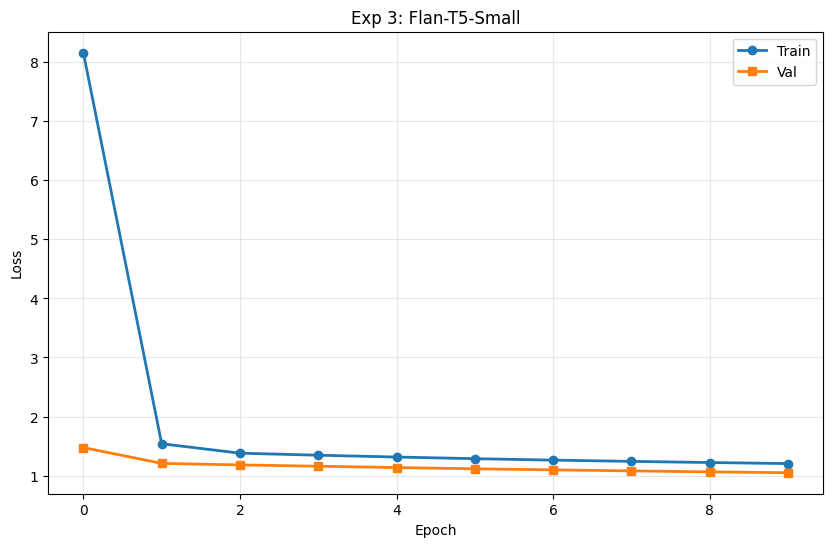

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'o-', label='Train', lw=2)
plt.plot(history.history['val_loss'], 's-', label='Val', lw=2)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Exp 3: Flan-T5-Small')
plt.legend(); plt.grid(True, alpha=0.3)
plt.savefig('data/improved/experiment_3_training.png', dpi=300)
plt.show()
print(f"Best Val: {min(history.history['val_loss']):.4f}")


In [28]:
# Evaluation
def generate_answer(question, model, tokenizer):
    prefix = "Answer this medical question: "
    inputs = tokenizer(prefix + question, return_tensors='tf', max_length=MAX_INPUT_LENGTH, truncation=True)
    outputs = model.generate(**inputs, max_length=512, min_length=10, num_beams=4, early_stopping=True,
                            no_repeat_ngram_size=3, length_penalty=1.0, do_sample=False)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

print("Generating predictions...")
predictions, references = [], []
for i in range(min(20, len(test_df))):
    q = test_df.iloc[i]['question']
    predictions.append(generate_answer(q, model, tokenizer))
    references.append(test_df.iloc[i]['answer'])
    if (i+1) % 5 == 0: print(f"  {i+1}/200...")

bleu_result = bleu_metric.compute(predictions=predictions, references=[[r] for r in references])
rouge_result = rouge_metric.compute(predictions=predictions, references=references)
val_loss = min(history.history['val_loss'])

print("\\n" + "="*80)
print("📊 EXPERIMENT 3 RESULTS")
print("="*80)
print(f"BLEU:     {bleu_result['bleu']:.4f}")
print(f"ROUGE-L:  {rouge_result['rougeL']:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print("="*80)

# Save results
results = {
    'experiment_id': 'exp3_flan_t5_small',
    'experiment_name': 'Flan-T5-Small (Instruction-Tuned)',
    'model_name': MODEL_NAME,
    'model_params': int(model.num_parameters()),
    'hyperparameters': {'batch_size': BATCH_SIZE, 'learning_rate': LEARNING_RATE, 'epochs': EPOCHS,
                       'max_input_length': MAX_INPUT_LENGTH, 'max_target_length': MAX_TARGET_LENGTH},
    'metrics': {'bleu': float(bleu_result['bleu']), 'rougeL': float(rouge_result['rougeL']), 'val_loss': float(val_loss)},
    'training_time_seconds': training_time
}

Path('results').mkdir(exist_ok=True)
with open('results/experiment_3_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("\\n✓ Saved to results/experiment_3_results.json")


Generating predictions...
  5/200...
  10/200...
  15/200...
  20/200...
\n================================================================================
📊 EXPERIMENT 3 RESULTS
BLEU:     0.0243
ROUGE-L:  0.1870
Val Loss: 1.0489
\n✓ Saved to results/experiment_3_results.json


In [29]:
# Show sample predictions
print("\\n" + "="*80)
print("🔍 SAMPLE PREDICTIONS")
print("="*80)

for i in range(min(3, len(test_df))):
    q = test_df.iloc[i]['question']
    true_a = test_df.iloc[i]['answer']
    pred_a = predictions[i]

    print(f"\\nQ: {q}")
    print(f"True: {true_a[:150]}..." if len(true_a) > 150 else f"True: {true_a}")
    print(f"Pred: {pred_a[:150]}..." if len(pred_a) > 150 else f"Pred: {pred_a}")
    print("-" * 80)

\n================================================================================
🔍 SAMPLE PREDICTIONS
\nQ: How many people are affected by multiple lentigines syndrome ?
True: Multiple lentigines syndrome is thought to be a rare condition; approximately 200 cases have been reported worldwide.
Pred: Multiple lentigines syndrome is a rare condition that affects people with a variety of medical conditions. It is caused by a mutation in the gene that...
--------------------------------------------------------------------------------
\nQ: What is the outlook for Childhood Extracranial Germ Cell Tumors ?
True: Certain factors affect prognosis (chance of recovery) and treatment options. The prognosis (chance of recovery) and treatment options depend on the fo...
Pred: What is the outlook for Childhood Extracranial Germ Cell Tumors? The following is a list of signs and symptoms of childhood extracranial germ cell tum...
------------------------------------------------------------------------